In [1]:
import os
import gc

import numpy as np
import miditok
from miditok import REMI, TokenizerConfig
import librosa
import pandas as pd
import collections
import matplotlib.pyplot as plt
import seaborn as sns
from einops import rearrange

from typing import Optional
from itertools import chain
from pathlib import Path

/home/bk/miniconda3/envs/keras/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_563/834703770.py:8: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
from transformers import LEDConfig, LEDForConditionalGeneration

In [3]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.optim import Optimizer
from torch.nn import CrossEntropyLoss
import torchaudio

In [4]:
class Lion(Optimizer):
  r"""Implements Lion algorithm."""

  def __init__(self, params, lr=1e-4, betas=(0.9, 0.99), weight_decay=0.0):
    """Initialize the hyperparameters.

    Args:
      params (iterable): iterable of parameters to optimize or dicts defining
        parameter groups
      lr (float, optional): learning rate (default: 1e-4)
      betas (Tuple[float, float], optional): coefficients used for computing
        running averages of gradient and its square (default: (0.9, 0.99))
      weight_decay (float, optional): weight decay coefficient (default: 0)
    """

    if not 0.0 <= lr:
      raise ValueError('Invalid learning rate: {}'.format(lr))
    if not 0.0 <= betas[0] < 1.0:
      raise ValueError('Invalid beta parameter at index 0: {}'.format(betas[0]))
    if not 0.0 <= betas[1] < 1.0:
      raise ValueError('Invalid beta parameter at index 1: {}'.format(betas[1]))
    defaults = dict(lr=lr, betas=betas, weight_decay=weight_decay)
    super().__init__(params, defaults)

  @torch.no_grad()
  def step(self, closure=None):
    """Performs a single optimization step.

    Args:
      closure (callable, optional): A closure that reevaluates the model
        and returns the loss.

    Returns:
      the loss.
    """
    loss = None
    if closure is not None:
      with torch.enable_grad():
        loss = closure()

    for group in self.param_groups:
      for p in group['params']:
        if p.grad is None:
          continue

        # Perform stepweight decay
        p.data.mul_(1 - group['lr'] * group['weight_decay'])

        grad = p.grad
        state = self.state[p]
        # State initialization
        if len(state) == 0:
          # Exponential moving average of gradient values
          state['exp_avg'] = torch.zeros_like(p)

        exp_avg = state['exp_avg']
        beta1, beta2 = group['betas']

        # Weight update
        update = exp_avg * beta1 + grad * (1 - beta1)

        p.add_(update.sign_(), alpha=-group['lr'])

        # Decay the momentum running average coefficient
        exp_avg.mul_(beta2).add_(grad, alpha=1 - beta2)

    return loss

![dataset](images/Dataset.png)

In [10]:
a = [name.split(".")[0] for name in os.listdir("song2midi/dataset/song")]

In [11]:
b = [name.split(".")[:2] for name in os.listdir("song2midi/dataset/midi")]

In [12]:
[midi for midi in b if midi[0] in a]

[['1', '1'],
 ['10', '1'],
 ['2', '1'],
 ['3', '1'],
 ['4', '1'],
 ['5', '1'],
 ['6', '1'],
 ['7', '1'],
 ['8', '1'],
 ['9', '1']]

In [7]:
torch.cat([torch.rand((1, 128, 1024)), torch.rand((1, 1, 1024))], dim=-2).shape

torch.Size([1, 129, 1024])

In [14]:
(torch.tensor([1, 2, 3, 4, 5, 6, 7, 8, 9, 10]) + torch.tensor([1, 2, 3, 4, 5, 6, 7, 8, 9, 10]))

tensor([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20])

In [8]:
class ArrangerEmbedding(nn.Module):
  def __init__(self, arranger_ids=256, hidden_size=1024):
    super().__init__()
    self.embeddings = nn.Embedding(arranger_ids, hidden_size)

  def forward(self, arranger_id, mel_db):
    return torch.cat([self.embeddings(arranger_id), mel_db], dim=-2)

In [ ]:
class MusicDataset(Dataset):
    def __init__(self, tokenizer, embbeding, max_output_length=4096, music_folder="song2midi/dataset/song", midi_folder="song2midi/dataset/midi", compressor=None):
        self.tokenizer = tokenizer
        self.embbeding = embbeding
        self.max_output_length = max_output_length
        self.music_folder = music_folder
        self.midi_folder = midi_folder
        
        self.music_ids = [name.split(".")[0] for name in os.listdir(music_folder)]
        
        uncheck_midis = [name.split(".")[:2] for name in os.listdir(midi_folder)]
        self.midis = [midi for midi in uncheck_midis if midi[0] in self.music_ids] # [music_id, arranger_id]

    def __len__(self):
        return len(self.music_ids)
    
    def __getitem__(self, idx):
        music_id, arranger_id = self.midis[idx]

        # music
        music_path = os.path.join(self.music_folder, f"{music_id}.mp3")
        waveform, sr = torchaudio.load(music_path)

        if waveform.shape[0] > 1:
            waveform = waveform.mean(dim=0, keepdim=True)

        mel_transform = torchaudio.transforms.MelSpectrogram(sample_rate=sr)
        mel = mel_transform(waveform)
        mel_db = torchaudio.transforms.AmplitudeToDB()(mel)

        input_embed = self.embbeding(torch.tensor([[int(arranger_id)]]), mel_db)
        attention_mask = torch.ones(input_embed.shape[:2])

        global_attention_mask = torch.zeros(input_embed.shape[:2])
        global_attention_mask[:, 0] = 1

        # midi
        midi_path = os.path.join(self.midi_folder, f"{music_id}.{arranger_id}.mid")
        midi = torch.tensor(self.tokenizer.encode(midi_path))
        midi = torch.cat([torch.tensor([self.tokenizer["BOS_None"]]), midi, torch.tensor([self.tokenizer["EOS_None"]])], dim=-1)

        # padding with -100
        if midi.shape[0] < self.max_output_length:
            midi = torch.cat([midi, torch.ones(self.max_output_length - midi.shape[0]) * -100], dim=-1)
        else:
            midi = midi[:self.max_output_length]

        return {"input_embed": input_embed, "attention_mask": attention_mask, "global_attention_mask": global_attention_mask, "labels": midi}


In [47]:
test, sr = torchaudio.load("song2midi/dataset/song/1.mp3")

In [49]:
test = test.mean(dim=0, keepdim=True)

In [51]:
mel_transform = torchaudio.transforms.MelSpectrogram(sample_rate=sr)

/home/bk/miniconda3/envs/keras/lib/python3.11/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [52]:
mel = mel_transform(test)

In [54]:
mel_db = torchaudio.transforms.AmplitudeToDB()(mel)

In [55]:
mel_db

torch.Size([1, 128, 22314])

In [63]:
conv = nn.AdaptiveMaxPool1d(1024)

<Axes: >

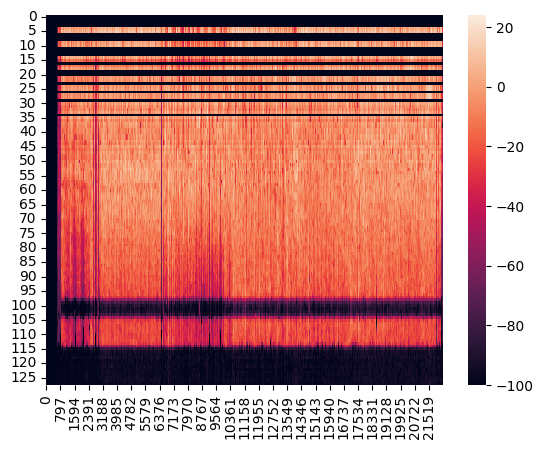

In [65]:
sns.heatmap(mel_db[0])

<Axes: >

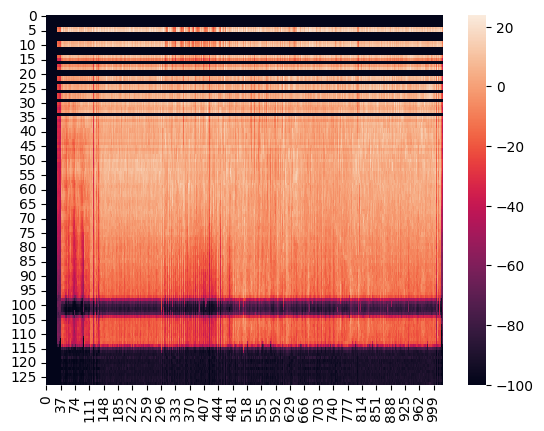

In [67]:
sns.heatmap(conv(mel_db)[0])

In [15]:
TOKENIZER_PARAMS = {
    "pitch_range": (0, 127),
    "beat_res": {(0, 4): 8, (4, 12): 4},
    "num_velocities": 32,
    "special_tokens": ["PAD", "BOS", "EOS", "MASK"],
    "use_chords": True,
    "use_rests": False,
    "use_tempos": True,
    "use_time_signatures": False,
    "use_programs": False,
    "num_tempos": 32,  # number of tempo bins
    "tempo_range": (40, 250),  # (min, max)
}
remi_config = TokenizerConfig(**TOKENIZER_PARAMS)

/tmp/ipykernel_563/2731034332.py:14: UserWarning: The special token PAD_None is present twice in your configuration. Skipping its duplicated occurrence.
  remi_config = TokenizerConfig(**TOKENIZER_PARAMS)


In [16]:
tokenizer = REMI(remi_config)

In [ ]:
dataset = MusicDataset(tokenizer, ArrangerEmbedding(), max_output_length=4096)

In [17]:
midi_paths = list(Path("song2midi", "dataset", "midi").glob("*.mid"))

tokenizer.train(vocab_size=50265, files_paths=midi_paths)

In [38]:
torch.tensor(tokenizer.encode(midi_paths[1])).squeeze(0).shape

torch.Size([514])

In [46]:
torch.cat([torch.tensor([tokenizer["BOS_None"]]), torch.tensor(tokenizer.encode(midi_paths[1])).squeeze(0), torch.tensor([tokenizer["EOS_None"]])], dim=-1)

tensor([    1,  1782, 33547, 46489, 24740, 24859, 25046, 35327, 30016, 25902,
        26131, 26351, 26620, 35581,  4965, 31132, 24978, 25252, 25413, 25571,
        37359, 48484, 26945, 32755, 36996, 41164, 37344, 42376, 45261, 43822,
        49963, 26924, 32770, 24920, 25169, 25324, 25547, 25745, 25889, 47998,
        26828, 27027, 34785, 24976, 37781, 48338, 26277, 26561, 40812,   425,
        32768, 37001, 47960, 23906, 40813, 45137, 49910, 26703, 26943, 32750,
        24851, 25064, 25303, 48064, 41165, 26507, 26781, 27055, 31147, 24927,
        25165, 25427, 25630, 47359, 36347, 35994, 33378, 41722, 25539, 47041,
        50087, 26390, 26672, 26831, 27222, 46962, 35321, 41179, 48873, 26545,
        41302, 48225, 31141, 25033, 37776, 25668, 41268, 38033, 43699, 26508,
        38555, 23511, 32769, 24929, 45172, 49728, 49973,  1062, 31168, 40392,
        43961, 40724, 26329, 47118, 46394, 36396, 40060, 25771, 38869, 40719,
        38599, 25308, 36434, 28520, 40713, 42526, 48025, 26026, 

In [25]:
tokenizer["EOS_None"]

2

In [11]:
tokenizer.save_params(Path("song2midi", "dataset", "midi", "tokenizer_params.json"))

In [46]:
Path("song2midi", "dataset", "tokens").absolute()

PosixPath('/mnt/c/Users/User/Desktop/Projects/labs/song2midi/dataset/tokens')

In [79]:
def validate_midi(midi):
    miditok.utils.merge_same_program_tracks(midi.tracks)
    return True

In [80]:
tokenizer.tokenize_dataset(        # 2 velocity and 1 duration values
    files_paths=Path("song2midi", "dataset", "midi").absolute(),
    out_dir=Path("song2midi", "dataset", "tokens"),
    validation_fn=validate_midi
)

Tokenizing music files (dataset/tokens):   0%|                                      | 0/132 [00:00<?, ?it/s]

Tokenizing music files (dataset/tokens): 100%|████████████████████████████| 132/132 [00:04<00:00, 28.18it/s]


In [84]:
miditok.pytorch_data.split_files_for_training(
    list(Path("song2midi", "dataset", "midi").absolute().glob("*.mid")),
    tokenizer,
    Path("song2midi", "dataset", "chunks"),
    max_seq_len=512,
)

Splitting music files (song2midi/dataset/chunks): 100%|███████████████████| 132/132 [00:02<00:00, 62.14it/s]


[PosixPath('song2midi/dataset/chunks/A Tender Feeling_0.mid'),
 PosixPath('song2midi/dataset/chunks/Accel World - Bye Bye_0.mid'),
 PosixPath('song2midi/dataset/chunks/Again_tv_t0_0.mid'),
 PosixPath('song2midi/dataset/chunks/Again_tv_t1_0.mid'),
 PosixPath('song2midi/dataset/chunks/Angel Beats! - Ichiban no Takaramono 2017_t0_0.mid'),
 PosixPath('song2midi/dataset/chunks/Angel Beats! - Ichiban no Takaramono 2017_t1_0.mid'),
 PosixPath('song2midi/dataset/chunks/Aqua Terrarium _0.mid'),
 PosixPath('song2midi/dataset/chunks/Attack_on_Titan_OST_Omake_Pfadlib_t0_0.mid'),
 PosixPath('song2midi/dataset/chunks/Attack_on_Titan_OST_Omake_Pfadlib_t1_0.mid'),
 PosixPath('song2midi/dataset/chunks/Brave Song MIDI_0.mid'),
 PosixPath('song2midi/dataset/chunks/Catch the Moment SAO_t0_0.mid'),
 PosixPath('song2midi/dataset/chunks/Catch the Moment SAO_t1_0.mid'),
 PosixPath('song2midi/dataset/chunks/Chikatto_Chika_Chika_t0_0.mid'),
 PosixPath('song2midi/dataset/chunks/Chikatto_Chika_Chika_t1_0.mid'),
 

In [ ]:
def get_labels(midi_seq, filepath):
    pass

In [12]:
dataset = miditok.pytorch_data.DatasetMIDI(
    files_paths=list(Path("song2midi", "dataset", "chunks").glob("**/*.mid")),
    tokenizer=tokenizer,
    max_seq_len=512,
    bos_token_id=tokenizer["BOS_None"],
    eos_token_id=tokenizer["EOS_None"],
    func_to_get_labels=
)

In [16]:
collator = miditok.pytorch_data.DataCollator(tokenizer.pad_token_id, copy_inputs_as_labels=True, shift_labels=True)

In [17]:
dataloader = DataLoader(dataset, batch_size=1, collate_fn=collator)

In [18]:
for batch in dataloader:
    print(batch)
    break

{'input_ids': tensor([[    1,  2566, 36657,  1906,   630, 60219, 33779,   912, 29283, 13106,
           611,  3373, 60715,   747, 60191,  1862, 63281,  1770,   341, 18040,
          4354, 50352,  1776, 33256, 11482,  4821,  4592, 12864,   958,  4839,
          1250, 25966, 36657,  1122,  2146,  8260,  4370, 21308,  1200,   590,
           401, 10709, 49713,  1474, 14439, 10602,  9581,  4107,  1047,   695,
         20208, 48965, 13053,  1906,  8260,  8925, 21308,   398,   860,  2816,
         33176,  6536, 25230,  6625,  5109,  2146,  4655,  3748,  4656,  1393,
          3348,  2566, 10482,  2322, 33779,  6650,  5409, 17577, 22231,  4757,
          4656,  1336,  3348, 35307, 10602, 20918,  8145, 58326,  5871, 36700,
          1250,  4656,   860,  3348, 35308, 48071,  3408,  2498, 14851, 24328,
           712,   645,  2380, 60731,  9555, 24845, 20942,  1200, 32814, 10489,
          7592, 25108,  1122,  4130,  1066, 48244,  5000, 48864, 40072,  1562,
          5264, 39196, 11605,  8176,  

In [52]:
tokens = tokenizer("song2midi/dataset/midi/This_Game.mid")

In [53]:
len(tokens)

2

In [34]:
from transformers import SpeechEncoderDecoderModel, SpeechEncoderDecoderConfig, Wav2Vec2Config, MambaConfig, VisionEncoderDecoderConfig, VisionEncoderDecoderModel

In [35]:
encoder_config = Wav2Vec2Config()
decoder_config = MambaConfig(vocab_size=50265, add_cross_attention=True)

config = VisionEncoderDecoderConfig.from_encoder_decoder_configs(encoder_config, decoder_config)

model = VisionEncoderDecoderModel(config)

In [27]:
y, sr = librosa.load("song2midi/dataset/wav/Idol.wav", sr=16000)

In [28]:
FE = ASTFeatureExtractor()

In [29]:
mels = FE(y, sr, return_tensors="pt")

In [32]:
mels["input_values"].shape

torch.Size([1, 1024, 128])

In [36]:
model(inputs=mels, decoder_input_ids=torch.randint(0, 50265, (1, 512)))

ValueError: You have to specify pixel_values

In [9]:
model_config = LEDConfig(
    # vocab_size=tokenizer.vocab_size,
    vocab_size=50265,
    activation_function="mish",
    encoder_layers=8,
    decoder_layers=8,
    max_encoder_position_embeddings=16384,
    max_decoder_position_embeddings=16384,
    
)

model = LEDForConditionalGeneration(model_config).to("cuda")

In [24]:
out = model(inputs_embeds=torch.randn(1, 128, 1024).to("cuda"), decoder_input_ids=torch.randint(0, 50265, (1, 2041)).to("cuda"))

In [16]:
out.keys()

odict_keys(['logits', 'past_key_values', 'encoder_last_hidden_state'])

In [ ]:
miditok.utils.filter_dataset(Path("song2midi", "dataset", "midi").glob("*.mid"), )

In [55]:
from symusic import Score

In [71]:
aaa = Score("song2midi/dataset/midi/This_Game.mid")

In [77]:
miditok.utils.merge_same_program_tracks(aaa.tracks)

In [78]:
aaa

Score(ttype=Tick, tpq=480, begin=0, end=138155, tracks=1, notes=1488, time_sig=1, key_sig=4, markers=0, lyrics=0)

In [16]:
y, sr = librosa.load("song2midi/dataset/wav/Idol.wav")

In [17]:
y.shape, sr

((4978177,), 22050)

In [19]:
mel = librosa.feature.melspectrogram(y=y, sr=sr)

In [21]:
mel.shape

(128, 9724)

In [31]:
4978177 - 5418423

-440246